# Case study 

Data: HappyCustomerBank


### Problem description:

About Company

Happy Customer Bank is a mid-sized private bank which deals in all kinds of loans. They have presence across all major cities in India and focus on lending products. They have a digital arm which sources customers from the internet.


Problem

Digital arms of banks today face challenges with lead conversion, they source leads through mediums like search, display, email campaigns and via affiliate partners. Here Happy Customer Bank faces same challenge of low conversion ratio. They have given a problem to identify the customers segments having higher conversion ratio for a specific loan product so that they can specifically target these customers, here they have provided a partial data set for salaried customers only from the last 3 months. They also capture basic details about customers like gender, DOB, existing EMI, employer Name, Loan Amount Required, Monthly Income, City, Interaction data and many others. Let’s look at the process at Happy Customer Bank.

In above process, customer applications can drop majorly at two stages, at login and approval/ rejection by bank. Here we need to identify the segment of customers having higher disbursal rate in next 30 days.

Data Set

We have train and test data set, train data set has both input and output variable(s). Need to predict probability of disbursal for test data set.


Input variables:

- ID - Unique ID (can not be used for predictions)
- Gender- Sex
- City - Current City
- Monthly_Income - Monthly Income in rupees
- DOB - Date of Birth
- Lead_Creation_Date - Lead Created on date
- Loan_Amount_Applied - Loan Amount Requested (INR)
- Loan_Tenure_Applied - Loan Tenure Requested (in years)
- Existing_EMI - EMI of Existing Loans (INR)
- Employer_Name - Employer Name
- Salary_Account- Salary account with Bank
- Mobile_Verified - Mobile Verified (Y/N)
- Var5- Continuous classified variable
- Var1- Categorical variable with multiple levels
- Loan_Amount_Submitted- Loan Amount Revised and Selected after seeing Eligibility
- Loan_Tenure_Submitted- Loan Tenure Revised and Selected after seeing Eligibility (Years)
- Interest_Rate- Interest Rate of Submitted Loan Amount
- Processing_Fee- Processing Fee of Submitted Loan Amount (INR)
- EMI_Loan_Submitted- EMI of Submitted Loan Amount (INR)
- Filled_Form- Filled Application form post quote
- Device_Type- Device from which application was made (Browser/ Mobile)
- Var2- Categorical Variable with multiple Levels
- Source- Categorical Variable with multiple Levels
- Var4- Categorical Variable with multiple Levels

Outcomes:

- LoggedIn- Application Logged (Variable for understanding the problem – cannot be used in prediction)
- Disbursed- Loan Disbursed (Target Variable)

Source:

https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802

### Target metrics: 
- AUC
- Profit
  - classification as 1 cost 100
  - true positive gives 1000
  
Target: achieve the highest profit.

## Data Science bootcamp homework, 22.03.2020
#### Jakub Kozłowski

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
# from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_predict, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score
from sklearn.feature_selection import RFE

# from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve

from utils import *

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

C:\Users\jp_ko\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [2]:
%load_ext autoreload
%aimport utils
%autoreload 1

#### 1. Case study - tasks
    1.1. Przygotuj dane do klasyfikacji: 
        1.1.1. Wykonaj eksploarcyjną analizę danych
        1.1.2. Stwórz nowe zmienne, które mogą okazać się przydatne lub zmodyfikuj istniejące (np. DOB -> YOB)
        1.1.3. Uzupełnij braki w danych
        1.1.4. Wybierz zmienne kategoryczne i wykonaj encoding (metoda pd.get_dummies *pamiętaj o drop_first=True)
    1.2. Podzial dane na zbiór treningowy i testowy:
        1.2.1. Wydziel testową część zbioru, którą dołączyliśmy i odłóż na bok (brakuje tam zmiennej Disbursed więc nie możemy określić dokładności predykcji)
        1.2.2. Z pozostałego zbioru wydziel zbiór treningowy (do robienia CV) i testowy (do ostatecznych testów modeli)
    1.3. Przetestuj kilka metod radzenia sobie z niezbalansowanymi klasami w celu uzyskania największego zysku i/lub F1:
        1.3.1. Modyfikacja progu odcięcia dla prewdopodobieństawa predykcji klasy 1
        1.3.2. Wproawdzenie wag klas dla modeli, które to umożliwiają, tj.:
            - LogisticRegression
            - DecisionTreeClassifier
            - RandomForestClassifier
        1.3.3. Podstawowy lub zmodyfikowany undersampling dla walidacji krzyżowej (implementacja z zadania 2)
        1.3.4. Oversampling naiwny zgodnie z naszą implementacją
    1.4. Dla każdej z metod w 1.3. wykonaj dobór hiperparametrów, np. GridSearchCV lub RandomizedSearchCV
    1.5. Sporządź raport z uzyskiwanych maksymalnych zysków i F1 dla najlepszych modeli w ramach metod do obsługi niezbalansowanych klas i wybierz najlepszy :) 

In [3]:
def financial_score(y_true, y_pred):
    
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    
    prediction_cost = y_pred.sum() * 100
    prediction_gain = (y_true & y_pred).sum() * 1000
    
    return prediction_gain - prediction_cost

---
# 1. EDA

In [4]:
data_train = pd.read_csv('data/HappyCustomerBank/Train_nyOWmfK.csv', encoding='Windows-1250',
                         parse_dates=['DOB', 'Lead_Creation_Date'])
data_test = pd.read_csv('data/HappyCustomerBank/Test_bCtAN1w.csv', encoding='Windows-1250',
                         parse_dates=['DOB', 'Lead_Creation_Date'])

In [5]:
data_train.shape, data_test.shape

((87020, 26), (37717, 24))

In [6]:
data_train.head().T

,0,1,2,3,4
ID,ID000002C20,ID000004E40,ID000007H20,ID000008I30,ID000009J40
Gender,Female,Male,Male,Male,Male
City,Delhi,Mumbai,Panchkula,Saharsa,Bengaluru
Monthly_Income,20000,35000,22500,35000,100000
DOB,1978-05-23 00:00:00,1985-10-07 00:00:00,1981-10-10 00:00:00,1987-11-30 00:00:00,1984-02-17 00:00:00
Lead_Creation_Date,2015-05-15 00:00:00,2015-05-04 00:00:00,2015-05-19 00:00:00,2015-05-09 00:00:00,2015-05-20 00:00:00
Loan_Amount_Applied,300000,200000,600000,1e+06,500000
Loan_Tenure_Applied,5,2,4,5,2
Existing_EMI,0,0,0,0,25000
Employer_Name,CYBOSOL,TATA CONSULTANCY SERVICES LTD (TCS),ALCHEMIST HOSPITALS LTD,BIHAR GOVERNMENT,GLOBAL EDGE SOFTWARE


Concat train set and test set for further analysis. 

In [7]:
df = pd.concat([data_train, data_test])
df.reset_index(drop=True, inplace=True)

In [8]:
df.isna().sum()

ID                           0
Gender                       0
City                      1401
Monthly_Income               0
DOB                          0
Lead_Creation_Date           0
Loan_Amount_Applied        111
Loan_Tenure_Applied        111
Existing_EMI               111
Employer_Name              113
Salary_Account           16801
Mobile_Verified              0
Var5                         0
Var1                         0
Loan_Amount_Submitted    49535
Loan_Tenure_Submitted    49535
Interest_Rate            84901
Processing_Fee           85346
EMI_Loan_Submitted       84901
Filled_Form                  0
Device_Type                  0
Var2                         0
Source                       0
Var4                         0
LoggedIn                 37717
Disbursed                37717
dtype: int64

In [9]:
# profile = ProfileReport(df)
# profile.to_file(outputfile="happy_customer_report.html")

---
# 2. Feature Engineering

- Age - based on **YOB**

In [10]:
df['YOB'] = df['DOB'].dt.year
df.loc[df['YOB'] > 2010, 'YOB'] = df['YOB'] - 100
df['Age'] = 2015 - df['YOB']  # data comes from 2015, so customer's age in 2015 is calculated

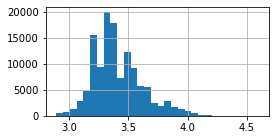

In [11]:
plt.figure(figsize=(4, 2))
np.log(df['Age']).hist(bins=30)

In [12]:
df['log_Age'] = np.log(df['Age'])

- **City**

In [13]:
top10_city_names = df.City.value_counts().index[:10]
def city_convert(x):
    if x in top10_city_names:
        return x
    else:
        return "Other"
    
df['City_converted'] = df['City'].apply(city_convert)
df['City_converted'].value_counts()

Other        37677
Delhi        17936
Bengaluru    15522
Mumbai       15425
Hyderabad    10410
Chennai       9895
Pune          7427
Kolkata       4282
Ahmedabad     2528
Jaipur        1892
Gurgaon       1743
Name: City_converted, dtype: int64

- **Monthly_Income**

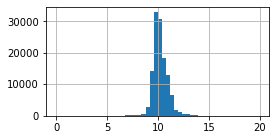

In [14]:
plt.figure(figsize=(4, 2))
np.log(df[df['Monthly_Income'] > 0]['Monthly_Income']).hist(bins=50)

C:\Users\jp_ko\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


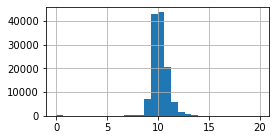

In [15]:
plt.figure(figsize=(4, 2))
df['log_Monthly_Income'] = np.log(df['Monthly_Income']).replace(-np.inf, 0)
df['log_Monthly_Income'].replace(-np.inf, 0).hist(bins=30)

- Get feature "days until end of the month" 
    - to check if bank clerks have monthly targets
- based on **Lead_Creation_Date**

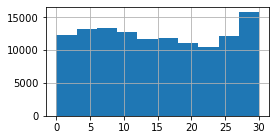

In [16]:
from pandas.tseries.offsets import MonthEnd

df['days_until_EOM'] = (df['Lead_Creation_Date'] + MonthEnd(0)) - df['Lead_Creation_Date']
df['days_until_EOM'] = df['days_until_EOM'].astype('timedelta64[D]')
plt.figure(figsize=(4, 2))
df['days_until_EOM'].hist(bins=10)

- Get feature: how many times monthly income of a person is bigger than amount applied

In [17]:
df['Loan_to_income'] = df['Monthly_Income'] / df['Loan_Amount_Applied']
df['Loan_to_income'] = df['Loan_to_income'].replace(np.inf, 0).replace(np.nan, 0)

- Get feature: if customer already has a credit or not (based on **Existing_EMI**

In [18]:
df['already_have_credit'] = (df['Existing_EMI'] > 0).astype(int)
df['already_have_credit'].value_counts(dropna=False)

0    83563
1    41174
Name: already_have_credit, dtype: int64

- **Salary Account** banks - transform

In [19]:
df['Salary_Account'].value_counts(dropna=False)[:10].sum() / df.shape[0]

0.8277736357295751

In [20]:
top10_accounts_names = df['Salary_Account'].value_counts().index[:10]
def account_convert(x):
    if x in top10_accounts_names:
        return x
    else:
        return "Other"
    
df['Salary_Account_converted'] = df['Salary_Account'].apply(account_convert)
df['Salary_Account_converted'].value_counts()

Other                   36609
HDFC Bank               25180
ICICI Bank              19547
State Bank of India     17110
Axis Bank               12590
Citibank                 3398
Kotak Bank               2955
IDBI Bank                2213
Punjab National Bank     1747
Bank of India            1713
Bank of Baroda           1675
Name: Salary_Account_converted, dtype: int64

- Get feature: **EMI_Loan_Submitted_missing**

In [21]:
df['missing_EMI_Loan_Submitted'] = df['EMI_Loan_Submitted'].isna().astype(int)

In [22]:
df[df['EMI_Loan_Submitted'].isna()==False]['Disbursed'].sum()

591.0

- Impute missing data for **Loan_Amount_Applied**

In [23]:
missing_data_mask = (df['Loan_Amount_Applied'] == 0) | (df['Loan_Amount_Applied'].isna())

df['Loan_Amount_Applied'] = impute_missing_values(df, 'Loan_Amount_Applied', missing_data_mask)

In [24]:
df['Loan_Amount_Applied'].value_counts()

100000.0     30831
200000.0     28125
300000.0     21358
500000.0     20774
1000000.0     9005
             ...  
475000.0         1
950000.0         1
275000.0         1
1340000.0        1
1550000.0        1
Name: Loan_Amount_Applied, Length: 319, dtype: int64

- Impute missing data for **Loan_Tenure_Applied**

In [25]:
missing_data_mask = (df['Loan_Tenure_Applied'] == 0) | (df['Loan_Tenure_Applied'].isna())

df['Loan_Tenure_Applied'] = impute_missing_values(df, 'Loan_Tenure_Applied', missing_data_mask)

In [26]:
df['Loan_Tenure_Applied'].value_counts()

5.0     45031
3.0     30751
2.0     21986
4.0     15709
1.0     11154
10.0       91
7.0         9
6.0         4
9.0         1
8.0         1
Name: Loan_Tenure_Applied, dtype: int64

- Impute missing data for **Loan_Tenure_Submitted**

In [27]:
missing_data_mask = (df['Loan_Tenure_Submitted'] == 0) | (df['Loan_Tenure_Submitted'].isna())

df['Loan_Tenure_Submitted'] = impute_missing_values(df, 'Loan_Tenure_Submitted', missing_data_mask)

In [28]:
df['Loan_Tenure_Submitted'].value_counts()

5.0    49462
4.0    36254
3.0    21124
2.0    12507
1.0     5384
6.0        6
Name: Loan_Tenure_Submitted, dtype: int64

- Impute missing data for **Loan_Amount_Submitted**

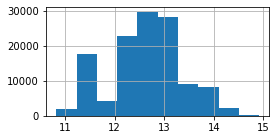

In [29]:
missing_data_mask = (df['Loan_Amount_Submitted'] == 0) | (df['Loan_Amount_Submitted'].isna())

df['Loan_Amount_Submitted'] = impute_missing_values(df, 'Loan_Amount_Submitted', missing_data_mask)
df['log_Loan_Amount_Submitted'] = np.log(df['Loan_Amount_Submitted'])

plt.figure(figsize=(4, 2))
df['log_Loan_Amount_Submitted'].hist()

- Impute missing data for **Loan_Amount_Applied**

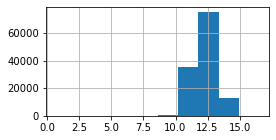

In [30]:
missing_data_mask = (df['Loan_Amount_Applied'] == 0) | (df['Loan_Amount_Applied'].isna())

df['Loan_Amount_Applied'] = impute_missing_values(df, 'Loan_Amount_Applied', missing_data_mask)
df['log_Loan_Amount_Applied'] = np.log(df['Loan_Amount_Applied'])

plt.figure(figsize=(4, 2))
df['log_Loan_Amount_Applied'].hist()

- **Mobile_Verified** get binary

In [31]:
df['Mobile_Verified'] = np.where(df['Mobile_Verified'] == 'Y', 1, 0)

- **Filled_Form** get binary

In [32]:
df['Filled_Form'] = np.where(df['Filled_Form'] == 'Y', 1, 0)

- **Source**

In [33]:
df['Source'] = recategorize_variable(df, 'Source', 2)
df['Source'].value_counts()

S122     55249
S133     42900
Other    26588
Name: Source, dtype: int64

- **Var1**

In [34]:
df['Var1'] = recategorize_variable(df, 'Var1', 1)
df['Var1'].value_counts()

HBXX     84901
Other    39836
Name: Var1, dtype: int64

- **Var2**

In [35]:
df['Var2'] = recategorize_variable(df, 'Var2', 2)
df['Var2'].value_counts()

B        53481
G        47338
Other    23918
Name: Var2, dtype: int64

---
## Initial Feature Selection
- drop already used and transformed variables
- drop meaningless fields (ex. ID)
- drop columns with overwhelming majority of missing values
- drop correlated variables

In [36]:
df.columns

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed', 'YOB', 'Age',
       'log_Age', 'City_converted', 'log_Monthly_Income', 'days_until_EOM',
       'Loan_to_income', 'already_have_credit', 'Salary_Account_converted',
       'missing_EMI_Loan_Submitted', 'log_Loan_Amount_Submitted',
       'log_Loan_Amount_Applied'],
      dtype='object')

In [37]:
cols_to_drop = ['City', 'DOB', 'EMI_Loan_Submitted', 'Employer_Name',
                'Existing_EMI', 'ID', 'Interest_Rate', 'Lead_Creation_Date',
                'Monthly_Income',
                'Loan_Amount_Applied', 'Loan_Amount_Submitted',
                'LoggedIn', 'Processing_Fee', 'Salary_Account', 'YOB', 'Age']

df2 = df.drop(columns=cols_to_drop)

### Correlation

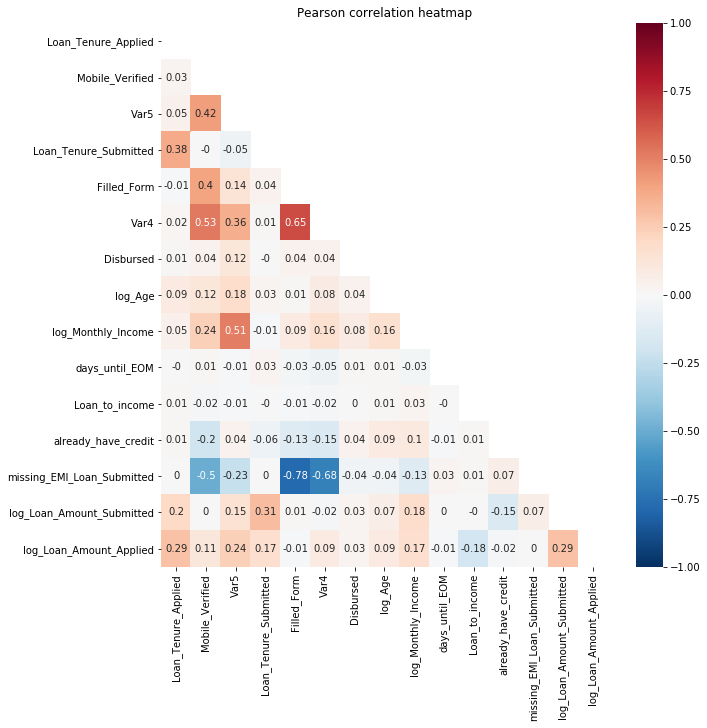

In [38]:
plot_corr_heatmap(df2, size=(10, 10))

In [39]:
# plot_corr_heatmap(df2, method='kendall', size=(10, 10))

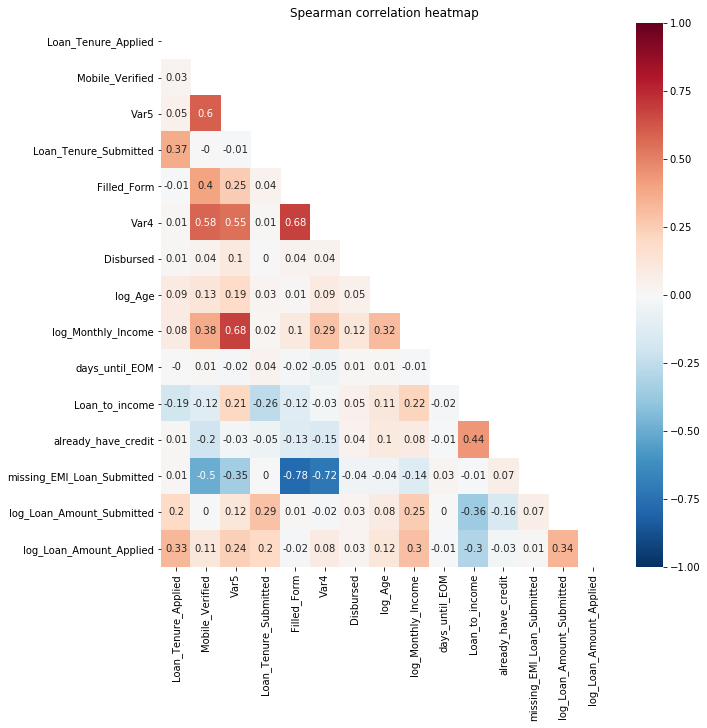

In [40]:
plot_corr_heatmap(df2, method='spearman', size=(10, 10))

**None of selected columns seems to be correlated (> 0.75 or < -0.75) hence I decide to keep all of them.**

---
## Encode variables and divide dataset into train and test sets

In [41]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124737 entries, 0 to 124736
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      124737 non-null  object 
 1   Loan_Tenure_Applied         124737 non-null  float64
 2   Mobile_Verified             124737 non-null  int32  
 3   Var5                        124737 non-null  int64  
 4   Var1                        124737 non-null  object 
 5   Loan_Tenure_Submitted       124737 non-null  float64
 6   Filled_Form                 124737 non-null  int32  
 7   Device_Type                 124737 non-null  object 
 8   Var2                        124737 non-null  object 
 9   Source                      124737 non-null  object 
 10  Var4                        124737 non-null  int64  
 11  Disbursed                   87020 non-null   float64
 12  log_Age                     124737 non-null  float64
 13  City_converted

In [42]:
categorical_variables = ['Device_Type', 'Gender',
       'Source', 'Var1', 'Var2', 'City_converted',
       'Salary_Account_converted']

df3 = pd.get_dummies(df2, columns=categorical_variables, drop_first=True)

df3.head(2)

,Loan_Tenure_Applied,Mobile_Verified,Var5,Loan_Tenure_Submitted,Filled_Form,Var4,Disbursed,log_Age,log_Monthly_Income,days_until_EOM,...,Salary_Account_converted_Bank of Baroda,Salary_Account_converted_Bank of India,Salary_Account_converted_Citibank,Salary_Account_converted_HDFC Bank,Salary_Account_converted_ICICI Bank,Salary_Account_converted_IDBI Bank,Salary_Account_converted_Kotak Bank,Salary_Account_converted_Other,Salary_Account_converted_Punjab National Bank,Salary_Account_converted_State Bank of India
0,5.0,0,0,4.0,0,1,0.0,3.610918,9.903488,16.0,...,0,0,0,1,0,0,0,0,0,0
1,2.0,1,13,2.0,0,3,0.0,3.401197,10.463103,27.0,...,0,0,0,0,1,0,0,0,0,0


### Separate train and test files, and split training set

In [43]:
df_train = df3.loc[:data_train.index.max()].copy()
df_test = df3.loc[data_train.index.max():].copy()

X = df_train.drop(columns=['Disbursed'])
y = df_train['Disbursed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1920, stratify=y)

In [44]:
y_train.sum(), y_test.sum()

(853.0, 420.0)

In [45]:
y_train.shape[0] / y_train.sum(), y_test.shape[0] / y_test.sum()

(68.35052754982415, 68.37380952380953)

----
# * Baseline model - without class reshaping

In [46]:
# DF to keep models performance
summary = pd.DataFrame()

In [47]:
tree = DecisionTreeClassifier(class_weight='balanced')
forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
logreg = LogisticRegression(penalty='l2', class_weight='balanced', n_jobs=-1)
# svc = SVC(class_weight='balanced', probability=True)

voting_clf = VotingClassifier(
#     estimators=[('tree', tree), ('forest', forest), ('logreg', logreg), ('svc', svc)],
    estimators=[('tree', tree), ('forest', forest), ('logreg', logreg)],
    voting='soft',
    n_jobs=-1
)

models_list = [tree, forest, logreg, voting_clf]

simplefilter(action='ignore', category=UserWarning)

for model in models_list:
    model_name = type(model).__name__ + '_baseline'
    print(model_name)
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    model_metrics = assess_model(model_name,
                                 y_test.values, y_pred_proba,
                                 metric_to_optimise_treshold='financial score',
                                 class_balancing='class weight balanced')
    summary = summary.append(model_metrics)
    
summary

DecisionTreeClassifier_baseline
RandomForestClassifier_baseline
LogisticRegression_baseline
VotingClassifier_baseline


,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.99,0.053724,0.973013,0.052381,-17900,0.519529,class weight balanced
0,RandomForestClassifier_baseline,0.19,0.051793,0.983424,0.030952,4800,0.514257,class weight balanced
0,LogisticRegression_baseline,0.90,0.106383,0.973674,0.107143,2400,0.546839,class weight balanced
0,VotingClassifier_baseline,0.65,0.026201,0.984469,0.014286,2200,0.506577,class weight balanced


---
## Undersampling

In [48]:
forest = RandomForestClassifier()

y_pred_proba, y_true = cv_undersampling(X.values, y.values, forest, size=1, cv=StratifiedKFold(5))
print(roc_auc_score(y_true=y_true, y_score=y_pred_proba))

0.8221214337863143


In [49]:
summary = summary.append(assess_model('Forest_baseline_undes', y_true, y_pred_proba,
                         metric_to_optimise_treshold='financial score',
                         class_balancing='cv_undersampling'))
summary

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.99,0.053724,0.973013,0.052381,-17900,0.519529,class weight balanced
0,RandomForestClassifier_baseline,0.19,0.051793,0.983424,0.030952,4800,0.514257,class weight balanced
0,LogisticRegression_baseline,0.90,0.106383,0.973674,0.107143,2400,0.546839,class weight balanced
0,VotingClassifier_baseline,0.65,0.026201,0.984469,0.014286,2200,0.506577,class weight balanced
0,Forest_baseline_undes,0.89,0.073184,0.980499,0.052632,11200,0.523453,cv_undersampling


## Oversampling

In [50]:
forest = RandomForestClassifier()

p, l = cross_validate_oversampling(X, y, forest, size=1, cv=StratifiedKFold(5))
print(roc_auc_score(y_true=l, y_score=p))

0.723961682851663


In [51]:
summary = summary.append(assess_model('Forest_baseline_overs', np.array(l), np.array(p),
                         metric_to_optimise_treshold='financial score',
                         class_balancing='cv_oversampling'))
summary

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.99,0.053724,0.973013,0.052381,-17900,0.519529,class weight balanced
0,RandomForestClassifier_baseline,0.19,0.051793,0.983424,0.030952,4800,0.514257,class weight balanced
0,LogisticRegression_baseline,0.90,0.106383,0.973674,0.107143,2400,0.546839,class weight balanced
0,VotingClassifier_baseline,0.65,0.026201,0.984469,0.014286,2200,0.506577,class weight balanced
0,Forest_baseline_undes,0.89,0.073184,0.980499,0.052632,11200,0.523453,cv_undersampling
0,Forest_baseline_overs,0.39,0.007710,0.985210,0.003928,2600,0.501853,cv_oversampling


# Feature Selection
### a) RFE

In [52]:
rfe = RFE(RandomForestClassifier(), 15, step=1)
rfe.fit(X_train, y_train)
X.columns[rfe.support_]

Index(['Loan_Tenure_Applied', 'Var5', 'Loan_Tenure_Submitted', 'Var4',
       'log_Age', 'log_Monthly_Income', 'days_until_EOM', 'Loan_to_income',
       'log_Loan_Amount_Submitted', 'log_Loan_Amount_Applied', 'Source_S122',
       'Source_S133', 'City_converted_Delhi',
       'Salary_Account_converted_HDFC Bank',
       'Salary_Account_converted_ICICI Bank'],
      dtype='object')

### b) Gradient Boosting feature importances with GridSearch
_careful, takes nearly 1 hour_

In [53]:
# n_estimators = range(50, 100, 10)
# max_depth = [3, 4, 5]
# min_samples_split = range(30, 50, 10)
# min_samples_leaf = range(20, 50, 10)

# features_gbc = []

# for n_est in n_estimators:
#     for max_d in max_depth:
#         for min_ss in min_samples_split:
#             for min_leaf in min_samples_leaf:
#                 GBC = GradientBoostingClassifier(
#                          verbose=2,
#                          n_estimators=n_est,
#                          max_depth=max_d,
#                          min_samples_leaf=min_leaf,
#                          min_samples_split=min_ss
#                 )
#                 GBC.fit(X_train, y_train)
#                 features_gbc.append(GBC.feature_importances_)

In [54]:
# features_gbc_avg = sum(features_gbc) / len(features_gbc)

### c) Random Forest with feature importances GridSearch

In [55]:
# n_estimators = [100, 150, 200]
# max_features = ['auto', 'sqrt', 'log2']
# max_depth = [4, 5, 6, 7, 8]
# criterion = ['gini', 'entropy']

# features_forest = []

# for n_est in n_estimators:
#     for max_f in max_features:
#         for max_d in max_depth:
#             for crit in criterion:
#                 RF = RandomForestClassifier(
#                          verbose=0,
#                          n_estimators=n_est,
#                          max_features=max_f,
#                          max_depth=max_d,
#                          criterion=crit,
#                          n_jobs=-1
#                 )
                
#                 RF.fit(X_train, y_train)
#                 y_pred_proba = model.predict_proba(X_test)[:,1]
    
# #                 model_name = type(model).__name__ + '_'.join([str(n_est), max_f, str(max_d), crit])
# #                 summary = summary.append(assess_model(model_name,
# #                                                       y_test.values, y_pred_proba,
# #                                                       metric_to_optimise_treshold='financial score',
# #                                                       class_balancing='class weight balanced'))
                
#                 features_forest.append(RF.feature_importances_)

In [56]:
# features_forest_avg = sum(features_forest) / len(features_forest)

In [57]:
# features_avg = (features_forest_avg + features_gbc_avg) / 2

# feature_importances_df = pd.DataFrame({'col': X_train.columns,
#                                        'importance': features_avg})
# feature_importances_df.sort_values('importance', ascending=False, inplace=True)

# ntop_feats = 15

# plt.figure(figsize=[6, 4])
# plt.title("Top features")
# plt.bar(range(ntop_feats), feature_importances_df['importance'].head(ntop_feats), color="r", align="center")
# plt.xticks(range(ntop_feats), feature_importances_df['col'].head(ntop_feats), rotation=90)
# plt.xlim([-1, ntop_feats])
# plt.show()

# features_to_keep = feature_importances_df['col'].head(ntop_feats)
# print(features_to_keep)

In [58]:
# features_to_keep.values

In [59]:
features_to_keep = ['log_Monthly_Income', 'Var5', 'Loan_to_income',
       'log_Loan_Amount_Submitted', 'log_Age', 'days_until_EOM',
       'log_Loan_Amount_Applied', 'Var4', 'already_have_credit',
       'Filled_Form', 'Salary_Account_converted_Other', 'Gender_Male',
       'Device_Type_Web-browser', 'Loan_Tenure_Applied',
       'missing_EMI_Loan_Submitted']

### GBC with undersampling

In [60]:
GBC_baseline = GradientBoostingClassifier()

y_pred_proba, y_true = cv_undersampling(X.values, y.values,
                                        GBC_baseline, size=1, cv=StratifiedKFold(5))

summary = summary.append(assess_model('GBC_baseline_unders', y_true, y_pred_proba, metric_to_optimise_treshold='financial score',
                            class_balancing='cv_undersampling'))
summary

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.99,0.053724,0.973013,0.052381,-17900,0.519529,class weight balanced
0,RandomForestClassifier_baseline,0.19,0.051793,0.983424,0.030952,4800,0.514257,class weight balanced
0,LogisticRegression_baseline,0.90,0.106383,0.973674,0.107143,2400,0.546839,class weight balanced
0,VotingClassifier_baseline,0.65,0.026201,0.984469,0.014286,2200,0.506577,class weight balanced
0,Forest_baseline_undes,0.89,0.073184,0.980499,0.052632,11200,0.523453,cv_undersampling
0,Forest_baseline_overs,0.39,0.007710,0.985210,0.003928,2600,0.501853,cv_oversampling
0,GBC_baseline_unders,0.99,0.000000,0.985371,0.000000,0,0.500000,cv_undersampling


### Same models with top best features

In [61]:
X_train2 = X_train[X_train.columns[X_train.columns.isin(features_to_keep)]]
X_test2 = X_test[X_test.columns[X_test.columns.isin(features_to_keep)]]

X2 = X[X.columns[X.columns.isin(features_to_keep)]]

In [62]:
GBC = GradientBoostingClassifier()

y_pred_proba, y_true = cv_undersampling(X2.values, y.values, GBC, size=1, cv=StratifiedKFold(5))
summary = summary.append(assess_model('GBC_topfeats', y_true, y_pred_proba, metric_to_optimise_treshold='financial score',
                                      class_balancing='cv_undersampling'))
summary

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.99,0.053724,0.973013,0.052381,-17900,0.519529,class weight balanced
0,RandomForestClassifier_baseline,0.19,0.051793,0.983424,0.030952,4800,0.514257,class weight balanced
0,LogisticRegression_baseline,0.90,0.106383,0.973674,0.107143,2400,0.546839,class weight balanced
0,VotingClassifier_baseline,0.65,0.026201,0.984469,0.014286,2200,0.506577,class weight balanced
0,Forest_baseline_undes,0.89,0.073184,0.980499,0.052632,11200,0.523453,cv_undersampling
0,Forest_baseline_overs,0.39,0.007710,0.985210,0.003928,2600,0.501853,cv_oversampling
0,GBC_baseline_unders,0.99,0.000000,0.985371,0.000000,0,0.500000,cv_undersampling
0,GBC_topfeats,0.93,0.009029,0.984866,0.004713,400,0.502065,cv_undersampling


In [63]:
GBC_topfeats1 = GradientBoostingClassifier(verbose=0,
                                 n_estimators=80,
                                 max_depth=3,
                                 min_samples_leaf=40,
                                 min_samples_split=40)

y_pred_proba, y_true = cv_undersampling(X2.values, y.values, GBC_topfeats1, size=1, cv=StratifiedKFold(5))
summary = summary.append(assess_model('GBC_topfeats1', y_true, y_pred_proba, metric_to_optimise_treshold='financial score',
                                      class_balancing='cv_undersampling'))
summary

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.99,0.053724,0.973013,0.052381,-17900,0.519529,class weight balanced
0,RandomForestClassifier_baseline,0.19,0.051793,0.983424,0.030952,4800,0.514257,class weight balanced
0,LogisticRegression_baseline,0.90,0.106383,0.973674,0.107143,2400,0.546839,class weight balanced
0,VotingClassifier_baseline,0.65,0.026201,0.984469,0.014286,2200,0.506577,class weight balanced
0,Forest_baseline_undes,0.89,0.073184,0.980499,0.052632,11200,0.523453,cv_undersampling
0,Forest_baseline_overs,0.39,0.007710,0.985210,0.003928,2600,0.501853,cv_oversampling
0,GBC_baseline_unders,0.99,0.000000,0.985371,0.000000,0,0.500000,cv_undersampling
0,GBC_topfeats,0.93,0.009029,0.984866,0.004713,400,0.502065,cv_undersampling
0,GBC_topfeats1,0.92,0.023460,0.984693,0.012569,6900,0.505847,cv_undersampling


In [65]:
tree = DecisionTreeClassifier(class_weight='balanced')
forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
logreg = LogisticRegression(penalty='l2', class_weight='balanced', n_jobs=-1)

voting_clf = VotingClassifier(
    estimators=[('tree', tree), ('forest', forest), ('logreg', logreg)],
    voting='soft',
    n_jobs=-1
)

models_list = [tree, forest, logreg, voting_clf]

simplefilter(action='ignore', category=UserWarning)

for model in models_list:
    model_name = type(model).__name__ + '_topfeats'
    print(model_name)
    
    model.fit(X_train2, y_train)
    y_pred_proba = model.predict_proba(X_test2)[:, 1]
    
    model_metrics = assess_model(model_name,
                                 y_test.values, y_pred_proba,
                                 metric_to_optimise_treshold='financial score',
                                 class_balancing='class weight balanced')
    summary = summary.append(model_metrics)
    
summary

DecisionTreeClassifier_topfeats
RandomForestClassifier_topfeats
LogisticRegression_topfeats
VotingClassifier_topfeats


,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.99,0.053724,0.973013,0.052381,-17900,0.519529,class weight balanced
0,RandomForestClassifier_baseline,0.19,0.051793,0.983424,0.030952,4800,0.514257,class weight balanced
0,LogisticRegression_baseline,0.90,0.106383,0.973674,0.107143,2400,0.546839,class weight balanced
0,VotingClassifier_baseline,0.65,0.026201,0.984469,0.014286,2200,0.506577,class weight balanced
0,Forest_baseline_undes,0.89,0.073184,0.980499,0.052632,11200,0.523453,cv_undersampling
0,Forest_baseline_overs,0.39,0.007710,0.985210,0.003928,2600,0.501853,cv_oversampling
0,GBC_baseline_unders,0.99,0.000000,0.985371,0.000000,0,0.500000,cv_undersampling
0,GBC_topfeats,0.93,0.009029,0.984866,0.004713,400,0.502065,cv_undersampling
0,GBC_topfeats1,0.92,0.023460,0.984693,0.012569,6900,0.505847,cv_undersampling
0,DecisionTreeClassifier_topfeats,0.99,0.027431,0.972838,0.026190,-27200,0.506540,class weight balanced


# GridSearch
### a) GradientBoostingClassifier without undersampling

In [66]:
n_estimators = range(50, 100, 10)
max_depth = [3, 4, 5]
min_samples_split = range(30, 50, 10)
min_samples_leaf = range(20, 50, 10)

features_gbc = []
models = {}

for n_est in n_estimators:
    for max_d in max_depth:
        for min_ss in min_samples_split:
            for min_leaf in min_samples_leaf:
                
                GBC = GradientBoostingClassifier(
                         verbose=1,
                         n_estimators=n_est,
                         max_depth=max_d,
                         min_samples_leaf=min_leaf,
                         min_samples_split=min_ss
                )
                GBC.fit(X_train, y_train)
                
                y_pred_proba = GBC.predict_proba(X_test)[:, 1]
    
                model_name = type(GBC).__name__ + '_'.join([str(n_est), str(max_d), str(min_ss), str(min_leaf)])
        
                models[model_name] = GBC
                
                summary = summary.append(assess_model(model_name,
                                                      y_test.values, y_pred_proba,
                                                      metric_to_optimise_treshold='financial score',
                                                      class_balancing='None'))

      Iter       Train Loss   Remaining Time 
         1           0.1487            4.46s
         2           0.1456            4.39s
         3           0.1435            4.32s
         4           0.1417            4.20s
         5           0.1401            4.10s
         6           0.1389            4.02s
         7           0.1378            3.92s
         8           0.1368            3.83s
         9           0.1359            3.75s
        10           0.1352            3.66s
        20           0.1308            2.74s
        30           0.1284            1.81s
        40           0.1270            0.90s
        50           0.1257            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1487            4.41s
         2           0.1456            4.34s
         3           0.1435            4.28s
         4           0.1417            4.16s
         5           0.1401            4.07s
         6           0.1389            3.98s
        

         2           0.1425            7.42s
         3           0.1395            7.25s
         4           0.1371            7.11s
         5           0.1350            6.97s
         6           0.1335            6.94s
         7           0.1319            6.77s
         8           0.1304            6.59s
         9           0.1293            6.43s
        10           0.1283            6.26s
        20           0.1198            4.64s
        30           0.1155            3.07s
        40           0.1123            1.53s
        50           0.1098            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1467            7.60s
         2           0.1426            7.49s
         3           0.1399            7.30s
         4           0.1375            7.12s
         5           0.1355            6.93s
         6           0.1335            6.78s
         7           0.1320            6.63s
         8           0.1305            6.48s
         

        50           0.1256            0.90s
        60           0.1243            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1476            7.20s
         2           0.1442            7.08s
         3           0.1416            6.95s
         4           0.1396            6.90s
         5           0.1380            6.81s
         6           0.1364            6.67s
         7           0.1351            6.53s
         8           0.1340            6.39s
         9           0.1329            6.26s
        10           0.1321            6.14s
        20           0.1260            4.87s
        30           0.1226            3.64s
        40           0.1204            2.41s
        50           0.1186            1.20s
        60           0.1171            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1476            7.26s
         2           0.1442            7.16s
         3           0.1417            7.03s
        

         4           0.1377            8.68s
         5           0.1357            8.50s
         6           0.1338            8.39s
         7           0.1324            8.25s
         8           0.1310            8.09s
         9           0.1295            7.93s
        10           0.1285            7.75s
        20           0.1214            6.18s
        30           0.1168            4.62s
        40           0.1139            3.04s
        50           0.1116            1.51s
        60           0.1095            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1487            6.35s
         2           0.1456            6.19s
         3           0.1435            6.12s
         4           0.1417            5.97s
         5           0.1401            5.89s
         6           0.1389            5.82s
         7           0.1378            5.71s
         8           0.1368            5.63s
         9           0.1359            5.54s
        1

      Iter       Train Loss   Remaining Time 
         1           0.1476            8.35s
         2           0.1442            8.33s
         3           0.1417            8.24s
         4           0.1397            8.13s
         5           0.1380            7.96s
         6           0.1364            7.81s
         7           0.1352            7.69s
         8           0.1340            7.56s
         9           0.1331            7.44s
        10           0.1322            7.31s
        20           0.1264            6.07s
        30           0.1229            4.82s
        40           0.1207            3.58s
        50           0.1188            2.38s
        60           0.1174            1.19s
        70           0.1160            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1476            8.49s
         2           0.1442            8.40s
         3           0.1417            8.29s
         4           0.1397            8.28s
        

        20           0.1308            5.53s
        30           0.1283            4.54s
        40           0.1269            3.62s
        50           0.1256            2.74s
        60           0.1243            1.85s
        70           0.1234            0.93s
        80           0.1225            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1487            7.34s
         2           0.1456            7.45s
         3           0.1435            7.52s
         4           0.1417            7.47s
         5           0.1401            7.36s
         6           0.1389            7.29s
         7           0.1378            7.25s
         8           0.1368            7.08s
         9           0.1359            6.95s
        10           0.1352            6.80s
        20           0.1308            5.79s
        30           0.1284            4.98s
        40           0.1270            4.07s
        50           0.1257            3.05s
        6

        40           0.1123            6.10s
        50           0.1098            4.56s
        60           0.1076            3.02s
        70           0.1054            1.50s
        80           0.1035            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1467           12.32s
         2           0.1426           12.25s
         3           0.1399           12.24s
         4           0.1375           12.14s
         5           0.1355           11.88s
         6           0.1335           11.69s
         7           0.1320           11.51s
         8           0.1305           11.41s
         9           0.1294           11.30s
        10           0.1284           11.25s
        20           0.1213            9.54s
        30           0.1169            7.91s
        40           0.1139            6.26s
        50           0.1111            4.76s
        60           0.1090            3.16s
        70           0.1070            1.57s
        8

        20           0.1308            6.23s
        30           0.1284            5.31s
        40           0.1270            4.40s
        50           0.1257            3.51s
        60           0.1245            2.63s
        70           0.1233            1.75s
        80           0.1224            0.87s
        90           0.1215            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1487            7.92s
         2           0.1456            7.87s
         3           0.1435            7.83s
         4           0.1417            7.72s
         5           0.1401            7.62s
         6           0.1389            7.53s
         7           0.1378            7.43s
         8           0.1368            7.32s
         9           0.1359            7.24s
        10           0.1352            7.14s
        20           0.1308            6.23s
        30           0.1283            5.31s
        40           0.1269            4.40s
        5

         4           0.1377           14.47s
         5           0.1357           14.25s
         6           0.1338           14.00s
         7           0.1324           13.80s
         8           0.1310           13.55s
         9           0.1295           13.35s
        10           0.1285           13.04s
        20           0.1214           11.01s
        30           0.1168            9.33s
        40           0.1139            7.73s
        50           0.1116            6.13s
        60           0.1095            4.61s
        70           0.1078            3.08s
        80           0.1064            1.55s
        90           0.1047            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1467           14.86s
         2           0.1425           14.43s
         3           0.1395           14.35s
         4           0.1371           14.10s
         5           0.1350           13.87s
         6           0.1335           13.59s
         

### b) GradientBoostingClassifier with undersampling

In [67]:
n_estimators = range(50, 100, 10)
max_depth = [3, 4, 5]
min_samples_split = range(30, 50, 10)
min_samples_leaf = range(20, 50, 10)

for n_est in n_estimators:
    for max_d in max_depth:
        for min_ss in min_samples_split:
            for min_leaf in min_samples_leaf:
                GBC = GradientBoostingClassifier(
                         verbose=0,
                         n_estimators=n_est,
                         max_depth=max_d,
                         min_samples_leaf=min_leaf,
                         min_samples_split=min_ss
                )
                
                model_name = type(GBC).__name__ + '_'.join([str(n_est), str(max_d), str(min_ss), str(min_leaf)])
#                 models[model_name] = GBC
                y_pred_proba, y_true = cv_undersampling(X.values, y.values,
                                                        GBC, size=1,
                                                        cv=StratifiedKFold(5))

                model_metrics = assess_model(model_name,
                                             y_true, y_pred_proba,
                                             metric_to_optimise_treshold='financial score',
                                             class_balancing='cv_undersampling')
        
                print(model_name, model_metrics['financial score'].values)
                summary = summary.append(model_metrics)

GradientBoostingClassifier50_3_30_20 [8600]
GradientBoostingClassifier50_3_30_30 [16200]
GradientBoostingClassifier50_3_30_40 [7700]
GradientBoostingClassifier50_3_40_20 [200]
GradientBoostingClassifier50_3_40_30 [5800]
GradientBoostingClassifier50_3_40_40 [1200]
GradientBoostingClassifier50_4_30_20 [0]
GradientBoostingClassifier50_4_30_30 [200]
GradientBoostingClassifier50_4_30_40 [2900]
GradientBoostingClassifier50_4_40_20 [3000]
GradientBoostingClassifier50_4_40_30 [6600]
GradientBoostingClassifier50_4_40_40 [2200]
GradientBoostingClassifier50_5_30_20 [3100]
GradientBoostingClassifier50_5_30_30 [600]
GradientBoostingClassifier50_5_30_40 [1500]
GradientBoostingClassifier50_5_40_20 [1800]
GradientBoostingClassifier50_5_40_30 [2300]
GradientBoostingClassifier50_5_40_40 [0]
GradientBoostingClassifier60_3_30_20 [10400]
GradientBoostingClassifier60_3_30_30 [6900]
GradientBoostingClassifier60_3_30_40 [300]
GradientBoostingClassifier60_3_40_20 [600]
GradientBoostingClassifier60_3_40_30 [890

In [68]:
summary.sort_values('financial score', ascending=False).head()

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,GradientBoostingClassifier70_5_30_40,0.10,0.155239,0.977261,0.142857,24700,0.566251,None
0,GradientBoostingClassifier70_5_40_40,0.10,0.155239,0.977261,0.142857,24700,0.566251,None
0,GradientBoostingClassifier80_5_40_40,0.10,0.154421,0.976355,0.147619,23700,0.568138,None
0,GradientBoostingClassifier80_5_30_40,0.10,0.154421,0.976355,0.147619,23700,0.568138,None
0,GradientBoostingClassifier60_5_30_40,0.09,0.155093,0.974580,0.159524,22600,0.573100,None


### c) XGBoost without undersampling

In [69]:
# n_estimators = range(50, 100, 10)
max_depth = [3, 4, 5]
min_samples_split = range(30, 50, 10)
min_samples_leaf = range(20, 50, 10)

n_estimators = [30, 32, 35, 38, 40, 42]
learning_rate = [0.1, 0.2, 0.25, 0.28, 0.3, 0.32]

models_xgb = {}

for n_est in n_estimators:
    for lr in learning_rate:
#         for min_ss in min_samples_split:
#             for min_leaf in min_samples_leaf:
                
        XGB = XGBClassifier(
                 verbose=1,
                 n_estimators=n_est,
                 learning_rate=lr,
                 n_jobs=-1
        )
        XGB.fit(X_train, y_train)

        y_pred_proba = XGB.predict_proba(X_test)[:, 1]

        model_name = type(XGB).__name__ + '_'.join(['_', str(n_est), str(lr)])

        models_xgb[model_name] = XGB

        model_metrics = assess_model(model_name,
                                     y_test, y_pred_proba,
                                     metric_to_optimise_treshold='financial score',
                                     class_balancing='None')
        
        print(model_name, model_metrics['financial score'].values[0])
        summary = summary.append(model_metrics)

XGBClassifier__30_0.1 13600
XGBClassifier__30_0.2 13900
XGBClassifier__30_0.25 17000
XGBClassifier__30_0.28 15100
XGBClassifier__30_0.3 10100
XGBClassifier__30_0.32 17600
XGBClassifier__32_0.1 15200
XGBClassifier__32_0.2 14800
XGBClassifier__32_0.25 15000
XGBClassifier__32_0.28 16200
XGBClassifier__32_0.3 12400
XGBClassifier__32_0.32 17200
XGBClassifier__35_0.1 14900
XGBClassifier__35_0.2 12700
XGBClassifier__35_0.25 16000
XGBClassifier__35_0.28 14900
XGBClassifier__35_0.3 12200
XGBClassifier__35_0.32 14800
XGBClassifier__38_0.1 16300
XGBClassifier__38_0.2 13400
XGBClassifier__38_0.25 13900
XGBClassifier__38_0.28 14700
XGBClassifier__38_0.3 13400
XGBClassifier__38_0.32 14300
XGBClassifier__40_0.1 15400
XGBClassifier__40_0.2 14600
XGBClassifier__40_0.25 14200
XGBClassifier__40_0.28 15200
XGBClassifier__40_0.3 21800
XGBClassifier__40_0.32 16100
XGBClassifier__42_0.1 17600
XGBClassifier__42_0.2 13800
XGBClassifier__42_0.25 10900
XGBClassifier__42_0.28 16100
XGBClassifier__42_0.3 21000
XGB

In [70]:
summary.sort_values('financial score', ascending=False).head(20)

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,GradientBoostingClassifier70_5_40_40,0.10,0.155239,0.977261,0.142857,24700,0.566251,None
0,GradientBoostingClassifier70_5_30_40,0.10,0.155239,0.977261,0.142857,24700,0.566251,None
0,GradientBoostingClassifier80_5_40_40,0.10,0.154421,0.976355,0.147619,23700,0.568138,None
0,GradientBoostingClassifier80_5_30_40,0.10,0.154421,0.976355,0.147619,23700,0.568138,None
0,GradientBoostingClassifier60_5_30_40,0.09,0.155093,0.974580,0.159524,22600,0.573100,None
0,GradientBoostingClassifier60_5_40_40,0.09,0.155093,0.974580,0.159524,22600,0.573100,None
0,GradientBoostingClassifier50_5_40_40,0.09,0.150246,0.975972,0.145238,21800,0.566770,None
0,GradientBoostingClassifier50_5_30_40,0.09,0.150246,0.975972,0.145238,21800,0.566770,None
0,XGBClassifier__40_0.3,0.09,0.158004,0.971794,0.180952,21800,0.582242,None
0,XGBClassifier__42_0.3,0.09,0.156250,0.971794,0.178571,21000,0.581069,None


In [71]:
y_pred_proba = models_xgb["XGBClassifier__40_0.25"].predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.11).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(financial_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     28297
         1.0       0.13      0.10      0.11       420

    accuracy                           0.98     28717
   macro avg       0.56      0.54      0.55     28717
weighted avg       0.97      0.98      0.98     28717

[[28034   263]
 [  380    40]]
9700
0.5429719118802768


# (in)famous GridSearch on XGBoost

In [72]:
eval_set = [(X_test, y_test)]

xgb_model = XGBClassifier(eval_metric="auc", eval_set=eval_set)
target_class_weight = int((y_train.shape[0] - y_train.sum()) / y_train.sum())

parameters = {'learning_rate': [0.01],
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [9, 10, 11],
#               'silent': [1],
#               'nthread': [4], #when use hyperthread, xgboost may become slower
#               'subsample': [0.8, 0.9, 0.95],
#               'colsample_bytree': [0.6, 0.7, 0.8],
#               'scale_pos_weight': [target_class_weight],
              'n_estimators': [1000]} #number of trees, change it to 1000 for better results}

grid_xgb = GridSearchCV(xgb_model,
                   parameters,
                   n_jobs=-1, 
                   cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2), 
                   scoring='roc_auc',
                   verbose=3, refit=True)

grid_xgb.fit(X_train, y_train)

y_pred_proba = grid_xgb.predict_proba(X_test)[:, 1]
tr = get_thresholds(y_test, y_pred_proba).sort_values('financial score', ascending=False)['thresholds'].values[0]
y_pred = (y_pred_proba > tr).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(financial_score(y_test, y_pred))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  5.9min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  6.0min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.6min finished


              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     28297
         1.0       0.12      0.22      0.16       420

    accuracy                           0.97     28717
   macro avg       0.56      0.60      0.57     28717
weighted avg       0.98      0.97      0.97     28717

[[27631   666]
 [  327    93]]
17100


In [73]:
model_metrics = assess_model(model_name,
                             y_test, y_pred_proba,
                             metric_to_optimise_treshold='financial score',
                             class_balancing='None')

print(model_name, model_metrics['financial score'].values[0])
summary = summary.append(model_metrics)

XGBClassifier__42_0.32 17100


In [74]:
def get_model_types(model_name_with_params):
    # Remove additional comments
    model_type = model_name_with_params.split('_')[0]
    
    # Remove values of parameters
    result = ''.join([char for char in model_type if not char.isdigit()])
    
    return result
    
summary['model_type'] = summary['model'].apply(get_model_types)

In [75]:
model_types_summary = summary.groupby(['model_type', 'class_balancing'], as_index=False)[['financial score', 'F1', 'roc_auc_score']].max()
model_types_summary.sort_values('financial score', ascending=False)

,model_type,class_balancing,financial score,F1,roc_auc_score
4,GradientBoostingClassifier,None,24700,0.158940,0.609762
9,XGBClassifier,None,21800,0.158004,0.610228
5,GradientBoostingClassifier,cv_undersampling,16200,0.070039,0.522045
2,Forest,cv_undersampling,11200,0.073184,0.523453
3,GBC,cv_undersampling,6900,0.023460,0.505847
7,RandomForestClassifier,class weight balanced,4800,0.069182,0.522763
1,Forest,cv_oversampling,2600,0.007710,0.501853
6,LogisticRegression,class weight balanced,2400,0.106383,0.546839
8,VotingClassifier,class weight balanced,2200,0.028986,0.507344
0,DecisionTreeClassifier,class weight balanced,-17900,0.053724,0.519529
